In [184]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy.stats import entropy
import pymc3


#import board

import time

# Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense


from tqdm.notebook import tqdm

In [128]:
start_time = time.time()
n = board.experiment()
print("--- %s seconds ---" % (time.time() - start_time))
print(n)
print(np.sum(n))

--- 0.06040239334106445 seconds ---
[  0.   2.   3.  15.  16.  25.  44.  68.  90.  86.  90. 101.  86.  86.
  87.  64.  43.  37.  27.  10.  10.   6.   2.   2.   0.   0.   0.   0.
   0.   0.   0.   0.]
1000.0


# Task 1: Simulator

In [345]:
nRows = 31

def simulator(alpha=0, s=0, n=1000):
    nslots = nRows+1 # Number of positions for marble in last row
    counts = np.zeros(nslots)
    
    nRight = np.zeros(n, dtype = int)
    M = np.zeros(n)
    
    rands = np.random.uniform(size = (n,nRows))

    for i in range(nRows):
        thres = 0.5 + alpha*M + s

        right = rands[:,i]<=thres
        nRight += right
        M = 0.5 - right

    for i in range(nslots):
        counts[i] = (nRight == i).sum()
        
    return counts
   
    
start_time = time.time()
print(simulator())
print("--- %s seconds ---" % (time.time() - start_time))
    
    

[  0.   0.   0.   0.   0.   0.   1.   1.   3.  10.  25.  37.  66.  84.
 128. 129. 148. 110.  99.  75.  48.  21.  13.   2.   0.   0.   0.   0.
   0.   0.   0.   0.]
--- 0.0032906532287597656 seconds ---


In [207]:
def gen_data(n_data, alpha = None):

    alphaData = np.random.rand(nData)*0.5
    sData = np.random.rand(nData)*0.5 - 0.25
    y = np.zeros((nData, 2))
    X = np.zeros((nData, nRows+1))

    for i in range(nData):
        if alpha != None:
            y[i,0] = alpha
        else:
            alpha = alphaData[i]
            y[i,0] = alpha
            
        s = sData[i]
        y[i,1] = s
        X[i,:] = simulator(alpha, s)
    return X, y # return experiments and labels

n_data = 1000
X,y = gen_data(n_data)

# Task 2: NN

In [6]:
def nn_model(X):
    input_shape = (X.shape[1],)
    model = keras.Sequential()
    # model.add(keras.Input(shape=input_shape))
    model.add(layers.Dense(32, input_shape=input_shape, activation="relu", kernel_initializer='random_normal'))
    model.add(layers.Dense(16, activation="relu", kernel_initializer='random_normal'))
    model.add(layers.Dense(8, activation="relu", kernel_initializer='random_normal'))
    # model.add(layers.Dense(3, activation="relu"))
    model.add(layers.Dense(2))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model
model = nn_model(X)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total params: 1,738
Trainable params: 1,738
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(x=X,
                    y=y,
                    epochs=500,
                    batch_size=32,
                    validation_split=0.7,
                    verbose=0)

Instructions for updating:
Use tf.cast instead.


dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


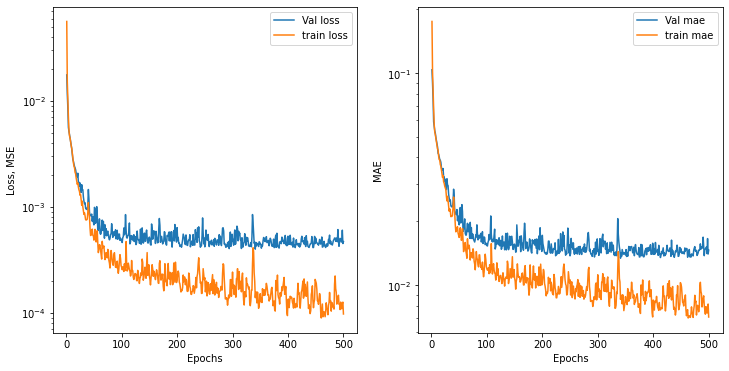

0.0146309305


In [16]:
# Plot training history
mae_history = history.history
print(mae_history.keys())
key = 'mean_absolute_error'
epochs = range(1, len(mae_history[key])+1)

fig, axs = plt.subplots(1, 2, figsize=(12,6))

axs[0].plot(epochs, mae_history['val_loss'], label='Val loss')
axs[0].plot(epochs, mae_history['loss'], label='train loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss, MSE')
axs[0].legend(loc='best')
axs[0].set_yscale('log')

axs[1].plot(epochs, mae_history['val_'+key], label='Val mae')
axs[1].plot(epochs, mae_history[key], label='train mae')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[1].legend(loc='best')
axs[1].set_yscale('log')
plt.show()

print(mae_history['val_'+key][-1])

## Task3

In [228]:
def kernel(y, y_obs, h = 0.1, statistic = "KL"):
    if statistic == "KL":
        entrop = entropy(pk = y, qk = y_obs)
    
    x = entrop/h
    sigma = 1/np.sqrt(2*np.pi) # choose the 
    return np.exp(-x**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)


nData = 100
    
y,labels = gen_data(nData)

theta = model.predict(y)
error = theta - labels

alpha_std = np.std(error[:,0])
s_std = np.std(error[:,1])


y_obs,_ = gen_data(nData, alpha = 0.2)

In [232]:
def ABC_MCMC(y_obs, gen_alpha = "prior", max_iter = 50, s_std = 0.01, alpha_std = 0.01):
    #gen_alpha = "NN"
    alpha = []
    for i, y_ob in tqdm(enumerate(y_obs)):

        theta_m = model.predict(y_ob.reshape(1,32))[0]
        s_m = theta_m[1]
        alpha_m = theta_m[0]
        
    
        for j in range(max_iter):
            start_time = time.time()
            s_star = np.random.normal(loc = s_m, scale  = s_std)
            
            if gen_alpha == "NN":
                alpha_star = np.random.normal(loc = alpha_m, scale  = alpha_std)
                y_star = simulator(alpha_star, s_star)
                kern = kernel(y_star, y_ob)

                norm = sc.stats.norm(loc=alpha_m, scale = alpha_std)
                M1 = norm.pdf(0)
                M2 = norm.pdf(0.5)
                M = 2*max((1/M1,1/M2))*1
                M=1

                p_acc = kern*2/(M*norm.pdf(alpha_star))
                #print(p_acc, M, M1, M2)
                
            else:
                alpha_star = np.random.rand()*0.5
                
                start_time2 = time.time()
                y_star = simulator(alpha_star, s_star)
                print("--- %s seconds ---" % (time.time() - start_time2))
                
                kern = kernel(y_star, y_ob)
                p_acc = kern
            
            if(np.random.rand() < p_acc):
                alpha.append(alpha_star)
                #break # ???
            print("--- %s seconds ---" % (time.time() - start_time))
            break
    return np.array(alpha) 

alpha = ABC_MCMC(y_obs, s_std = s_std)
print(alpha.shape)
print(alpha_star, s_star)

print(p_acc)

--- 0.021335840225219727 seconds ---
--- 0.021790027618408203 seconds ---
--- 0.015987157821655273 seconds ---
--- 0.01641392707824707 seconds ---
--- 0.014150857925415039 seconds ---
--- 0.014518022537231445 seconds ---
--- 0.014519929885864258 seconds ---
--- 0.014991044998168945 seconds ---
--- 0.015310049057006836 seconds ---
--- 0.015700817108154297 seconds ---
--- 0.014822006225585938 seconds ---
--- 0.0150909423828125 seconds ---
--- 0.010867118835449219 seconds ---
--- 0.01112675666809082 seconds ---
--- 0.011028051376342773 seconds ---
--- 0.011237859725952148 seconds ---
--- 0.013168096542358398 seconds ---
--- 0.013389110565185547 seconds ---
--- 0.01050424575805664 seconds ---
--- 0.010733842849731445 seconds ---
--- 0.010680675506591797 seconds ---
--- 0.01090097427368164 seconds ---
--- 0.01300191879272461 seconds ---
--- 0.013356208801269531 seconds ---
--- 0.011013984680175781 seconds ---
--- 0.011252880096435547 seconds ---
--- 0.01055288314819336 seconds ---
--- 0.010

[0.12983388 0.41244621]


/Users/kevinandersson/opt/miniconda3/envs/Physics-env/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),


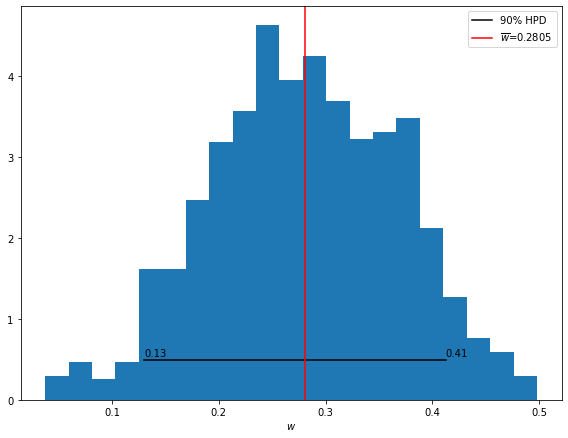

In [230]:



fig,ax = plt.subplots(figsize = (8,6))
ax.hist(alpha ,bins = 21, density = True)

hdi = pymc3.stats.hpd(alpha, 0.90)
print(hdi)
ymax = ax.get_ylim()[1]
ax.plot(hdi, [ymax/10, ymax/10], c='k', label='90% HPD')
ax.axvline(np.mean(alpha), c='r', label=r'$\overline{w}$'+f'={np.mean(alpha):.4f}')
ax.text(hdi[0], ymax/9, s=f'{hdi[0]:.2f}')
ax.text(hdi[1], ymax/9, s=f'{hdi[1]:.2f}')
plt.tight_layout()
ax.set_xlabel(r'$w$')
ax.legend(loc='best')
#plt.savefig('figures_task2/w_posterior.png')